In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add the project root to the Python path to allow imports from other directories
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Add the data directory to the Python path
data_dir = os.path.join(project_root, 'data')
models_dir = os.path.join(project_root, 'models')
optimizers_dir = os.path.join(project_root, 'optimizers')

sys.path.append(models_dir)
sys.path.append(optimizers_dir)

sys.path.append(data_dir)
sys.path.append(models_dir)
sys.path.append(optimizers_dir)

from models.architectures import initialize_parameters, forward_pass
from optimizers.backpropagation import (
    compute_loss, 
    backpropagate, 
    initialize_velocity, 
    update_parameters
)
from data.loaders import load_raw_data, split_train_val_test
from data.preprocessors import preprocess_data

In [2]:
# Define file paths
train_file_path = os.path.join(data_dir, 'raw', 'Train.csv')

# Load the raw data
train_data = load_raw_data(train_file_path)

print("Train data shape:", train_data.shape)

# Display the first few rows and data info of the train dataset
print("\nFirst few rows of the train dataset:")
print(train_data.head())
print("\nTrain dataset info:")
train_data.info()

Train data shape: (140160, 12)

First few rows of the train dataset:
   Unnamed: 0              Time  Location  Temp_2m  RelHum_2m      DP_2m  \
0           0  02-01-2013 00:00         1  28.2796  84.664205  24.072595   
1           1  02-01-2013 01:00         1  28.1796  85.664205  24.272595   
2           2  02-01-2013 02:00         1  26.5796  90.664205  24.072595   
3           3  02-01-2013 03:00         1  27.1796  87.664205  23.872595   
4           4  02-01-2013 04:00         1  27.0796  87.664205  23.672595   

     WS_10m   WS_100m      WD_10m     WD_100m    WG_10m     Power  
0  1.605389  1.267799  145.051683  161.057315  1.336515  0.163496  
1  2.225389  3.997799  150.051683  157.057315  4.336515  0.142396  
2  1.465389  2.787799  147.051683  149.057315  3.136515  0.121396  
3  1.465389  2.697799   57.051683  104.057315  1.536515  0.100296  
4  2.635389  4.437799   57.051683   83.057315  3.936515  0.079296  

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [3]:
# Drop 'Unnamed: 0', 'Time', and 'Location' columns
train_data = train_data.drop(columns=['Unnamed: 0', 'Time', 'Location'], errors='ignore')

# Split the data into training, validation, and test sets
train_df, val_df, test_df = split_train_val_test(train_data, test_ratio=0.15, val_ratio=0.15, random_state=42)

print("\nAfter splitting:")
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


After splitting:
Training set shape: (98112, 9)
Validation set shape: (21024, 9)
Test set shape: (21024, 9)


In [4]:
input_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 'WD_10m', 'WD_100m', 'WG_10m']
output_column = 'Power'

# Isolate input and output variables in training validation, and test sets
train_X = train_df[input_columns]
train_y = train_df[output_column]

val_X = val_df[input_columns]
val_y = val_df[output_column]

test_X = test_df[input_columns]
test_y = test_df[output_column]

# Preprocess (scale) the input features
train_X_scaled = preprocess_data(train_X)
val_X_scaled = preprocess_data(val_X)
test_X_scaled = preprocess_data(test_X)

# Scale the output target values
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1))
val_y_scaled = scaler_y.transform(val_y.reshape(-1, 1))

Epoch 0 - Train Loss: 1.1360, Val Loss: 1.1443
Epoch 10 - Train Loss: 1.1360, Val Loss: 1.1442
Epoch 20 - Train Loss: 1.1359, Val Loss: 1.1441
Epoch 30 - Train Loss: 1.1358, Val Loss: 1.1441
Epoch 40 - Train Loss: 1.1358, Val Loss: 1.1440
Epoch 50 - Train Loss: 1.1357, Val Loss: 1.1439
Epoch 60 - Train Loss: 1.1356, Val Loss: 1.1438
Epoch 70 - Train Loss: 1.1355, Val Loss: 1.1437
Epoch 80 - Train Loss: 1.1354, Val Loss: 1.1436
Epoch 90 - Train Loss: 1.1353, Val Loss: 1.1435


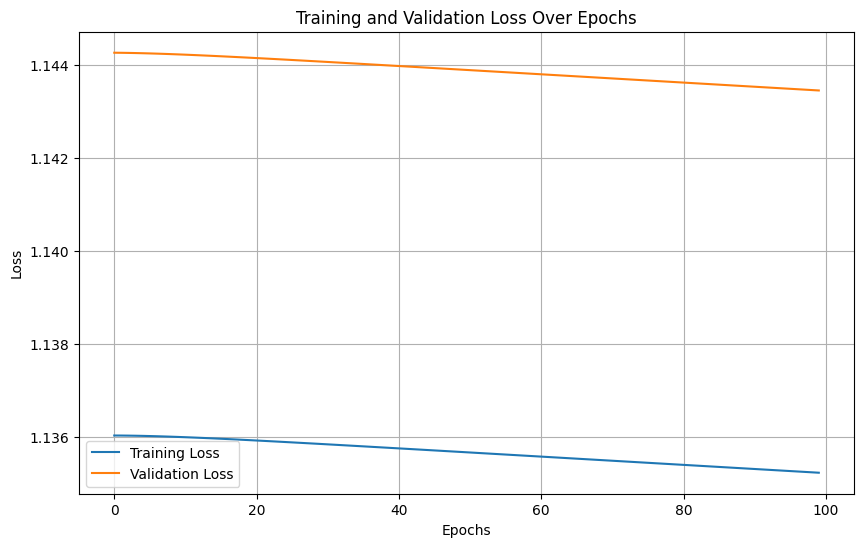

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters and velocity terms
params = initialize_parameters()
velocities = initialize_velocity(params)

# Set hyperparameters
learning_rate = 0.1
beta = 0.9  # Momentum factor
epochs = 100

# Store loss history for monitoring
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    # Step 1: Forward pass on the training data
    A4_train, cache_train = forward_pass(train_X_scaled, params)

    # Step 2: Compute training loss
    train_loss = compute_loss(train_y_scaled, A4_train)
    train_loss_history.append(train_loss)

    # Step 3: Backpropagation to compute gradients
    grads = backpropagate(train_X_scaled, train_y_scaled, cache_train, params)

    # Step 4: Update parameters with gradient descent and momentum
    params, velocities = update_parameters(params, grads, velocities, learning_rate, beta)

    # Compute validation loss to monitor performance
    A4_val, _ = forward_pass(val_X_scaled, params)
    val_loss = compute_loss(val_y_scaled, A4_val)
    val_loss_history.append(val_loss)

    # Print the loss every 10 epochs for monitoring
    if epoch % 10 == 0:
        # Convert to float if train_loss and val_loss are Series or DataFrame
        train_loss_value = float(train_loss) if hasattr(train_loss, 'iloc') else train_loss
        val_loss_value = float(val_loss) if hasattr(val_loss, 'iloc') else val_loss
        print(f'Epoch {epoch} - Train Loss: {train_loss_value:.4f}, Val Loss: {val_loss_value:.4f}')

# After training, plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()